In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

This commmand assumes the csv file has been generated previously. To generate the file, see: 0_data_generation.py

In [2]:
# Load the data (assuming the CSV file generated previously)
df = pd.read_csv('src_files/f1_lap_times_with_edge_cases.csv')

In [3]:
# Display the count of null values per column
nan_counts = df.isna().sum()
print(nan_counts)

Driver    3
Time      1
dtype: int64


In [15]:


# Step 1: Remove empty values (NaN or None)
df_cleaned = df.dropna(subset=['Time'])  # Drop rows where 'Time' is NaN
df_cleaned = df_cleaned.dropna(subset=['Driver']) # Drop rows where 'Driver' is NaN

# Step 2: Remove rows with wrong data types (non-numeric lap times)
# Convert 'Time' column to numeric, coercing errors into NaN, then drop those rows
df_cleaned['Time'] = pd.to_numeric(df_cleaned['Time'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['Time'])

# Remove rows where 'Driver' is a number
df_cleaned = df_cleaned[~df_cleaned['Driver'].apply(lambda x: x.isdigit())]


# Step 3: Remove duplicates
df_cleaned = df_cleaned.drop_duplicates()


In [16]:
df_cleaned.head()

Driver  Time
0  Fangio  4.27
1  Fangio  3.13
2  Fangio  2.26
3  Fangio  2.02
4  Fangio  5.76

Now, let's see if there are outliers/ junk values in the Time variable

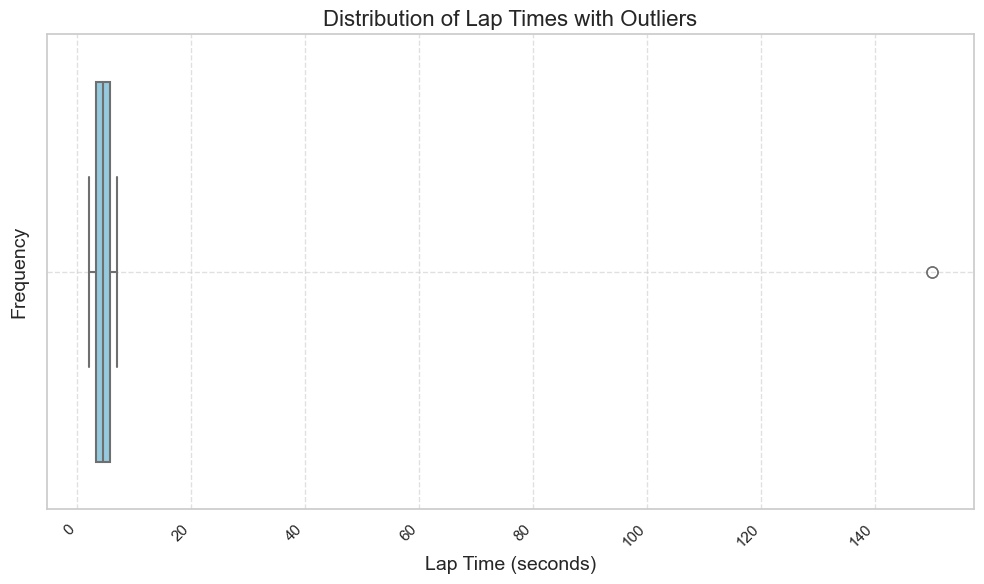

In [17]:
# Set Seaborn style
sns.set(style="whitegrid")

# Create a box plot for the 'Time' column to detect outliers
plt.figure(figsize=(10, 6)) 
sns.boxplot(x=df_cleaned['Time'], color='skyblue', fliersize=8, linewidth=1.5)

# Add titles and labels
plt.title('Distribution of Lap Times with Outliers', fontsize=16)
plt.xlabel('Lap Time (seconds)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Rotate x-axis labels to avoid overlap (if applicable)
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees for better spacing

# Add grid lines for easier interpretation
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust layout to ensure no overlap of labels
plt.tight_layout()  # Adjust layout to make everything fit properly
plt.show()

The skyblue box is the are where the "majority" of data points are at (meaning, points around the mean and an acceptable standard deviation). We want to clean data from the outliers (where Lap time = 0, 100, 150, 200) as these could affect the calculation of average

In [18]:
# Step 4: Remove outliers

#remove values that are below a threshold. in my case, I will set the threshold to 1

df_cleaned = df_cleaned[df_cleaned['Time'] > 1] 

#Identify and remove outliers using both Z-score and IQR

# Z-score method:
z_scores = stats.zscore(df_cleaned['Time'])
threshold_z = 3  # Set a strict threshold for Z-scores
df_cleaned = df_cleaned[np.abs(z_scores) < threshold_z]

# IQR method:
Q1 = df_cleaned['Time'].quantile(0.25)
Q3 = df_cleaned['Time'].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds for detecting outliers using IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows where 'Time' is outside of the IQR bounds
df_cleaned = df_cleaned[(df_cleaned['Time'] >= lower_bound) & (df_cleaned['Time'] <= upper_bound)]

# Now, df_cleaned should have removed extreme outliers (e.g., 100, 200, 300)
print(df_cleaned.head())


   Driver  Time
0  Fangio  4.27
1  Fangio  3.13
2  Fangio  2.26
3  Fangio  2.02
4  Fangio  5.76


Now, I will enforce the rule in our dataset: "Make sure you have at least 10 drivers in your list with at least 3 lap times each"

In [19]:
#Group by 'Driver' and count the lap times for each driver
driver_counts = df_cleaned.groupby('Driver').size()
print(driver_counts)

Driver
Alonso        17
Brabham       18
Clark         17
Fangio        18
Fittipaldi    17
Hakkinen      16
Hamilton      17
Hill          17
Hunt          17
Lauda         18
Moss          17
Piquet        30
Prost         17
Raikkönen     18
Rosberg       18
Schumacher    18
Senna         18
Stewart       16
Vettel        16
dtype: int64


In [20]:
#Filter out drivers with fewer than 3 lap times
valid_drivers = driver_counts[driver_counts >= 3].index
df_cleaned = df_cleaned[df_cleaned['Driver'].isin(valid_drivers)] #Filter the DataFrame to include only these valid drivers

#Check if we have at least 10 drivers
if df_cleaned['Driver'].nunique() < 10:
    raise ValueError("Not enough drivers with at least 3 lap times. You need at least 10 drivers.")




In [21]:
print(df_cleaned.head())

   Driver  Time
0  Fangio  4.27
1  Fangio  3.13
2  Fangio  2.26
3  Fangio  2.02
4  Fangio  5.76


In [22]:
df_cleaned.to_csv('src_files/f1_lap_times_cleaned.csv', index=False)